<a href="https://colab.research.google.com/github/Flatric/PMDS/blob/master/Code/Expected%20Deaths/Expected_Deaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excess Mortality Analysis

In this notebook we will attempt to calculate the excess deaths in Germany during the COVID-19 epidemic. We base our analysis on the dataset of weekly deaths since 2000 in Germany obtained from eurostat. Based on the trend and periodogram of the time series we generate numerical features that capture the temporal structure of the deaths in Germany enabling us to train and compare various machine learning algorithms that can then be used to predict the mortality of the time period starting from 2020 in the absence of corona. 
This prediction can then be compared to the actual mortality yielding an estimation for the number of excess deaths during the COVID-19 pandemic.

## 1. Data and relevant Libraries
We conduct our analysis using Python. The main libraries used are`scipy` which we use to analyze the seasonality of the weekly deaths, `statsmodels` for generating the temporal features used in our machine learning pipeline which itself is based `scikit-learn` and `matplotlib` for visualizing our results. Besides that we also use `pandas` and `numpy` to perform some auxillary tasks.

The data comes from [EuroStat](https://ec.europa.eu/eurostat/data/database) as an excel table containing the weekly Deaths in Germany from 2000 until now (March 2022). The preprocessing of this data is done by the custom function `data_loader` which returns the data as a pandas DataFrame. 

Additionaly we also created age standardized data for the death rate per 100000 in a given week based on the German population in 2020 as standard. Unfortunately this data set only includes the years from 2000 up to 2020.

In [ ]:
try: 
  import google.colab
  !pip install statsmodels==0.13.2
  !pip install matplotlib==3.5.1
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
def data_loader(name, IN_COLAB):
    try:
        import google.colab
        print("Pulling Data from GitHub.")
        !wget https://raw.githubusercontent.com/Flatric/PMDS/master/Code/Expected%20Deaths/Data/Germany%20Weekly%20Total%20Deaths%20Standardized.csv
        !wget https://raw.githubusercontent.com/Flatric/PMDS/master/Code/Expected%20Deaths/Data/Germany%20Weekly%20Total%20Deaths.csv
        data = pd.read_csv(f"{name}.csv",index_col=0)
    except:
        print("Getting Data from local Folder.")
        relative_path = "Data"
        data = pd.read_csv(f"{relative_path}\\{name}.csv",index_col=0)

    data = data[data != ":"].dropna()
    
    if name == "Germany Weekly Total Deaths":
        data["Value"] = data["Value"].str.replace("," , "")
        data["Value"] = data["Value"].apply(lambda value: value + "0"*(5-len(value))).astype("int")
        data.index = data.index.map(lambda date: date.replace("W","-")+"-1")
        
    elif name == "Germany Weekly Total Deaths Standardized":
         data = data.rename(columns={"Sterberate": "Value"})
         
    data.index = pd.to_datetime(data.index,format="%G-%V-%w")
    
    data.index.name = "Date"
    
    return data

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram, detrend
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Adjust color cycle of plots (first line HS-blue second line burgundy red, turqouise)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#0645ad", "#800020", "#1EB9E7", "#269F08"]) 
mpl.rcParams['figure.dpi'] = 100

# Create custom cmap for heatmaps.
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = [(242/255, 242/255, 223/255), (6/255 ,69/255 ,173/255 ),]
hs_cmp = LinearSegmentedColormap.from_list('testCmap', colors, N=100) #Is used to create the fraunhofer font.

## 2. Preparing the Data.
We discard all observations before 2008 since including them would distort the trend estimation for our model due to the fact that the demography or Germany is undergoing significant changes, since 2008 the mortality has been increasing linerarly specifically. 

The preprocessed data is then split into a training-, validation- and test-set. We use a validation set for comparing model performace. The test set contains the periods from 2020 onward, hence the time period since COVID-19 started to spread.

For our age standardized data we will only create a train and test set, since we will use the model with the best performance on the raw total death data for estimation of the age standardized deaths per 100000 in 2020. 

In [ ]:
# Raw Total Deaths.
Weekly_Deaths = data_loader("Germany Weekly Total Deaths", IN_COLAB)


Weekly_Deaths_train = Weekly_Deaths[(Weekly_Deaths.index.year < 2019)
                                    & (Weekly_Deaths.index.year >= 2008)]
Weekly_Deaths_val = Weekly_Deaths[Weekly_Deaths.index.year == 2019]
Weekly_Deaths_test = Weekly_Deaths[Weekly_Deaths.index.year > 2019]

# Age Standardized Total Deaths.
Weekly_Deaths_standardized = data_loader("Germany Weekly Total Deaths Standardized", IN_COLAB)

Weekly_Deaths_standardized_train = Weekly_Deaths_standardized[(Weekly_Deaths_standardized.index.year < 2020)
                                                              & (Weekly_Deaths_standardized.index.year >= 2008)]
Weekly_Deaths_standardized_test = Weekly_Deaths_standardized[Weekly_Deaths_standardized.index.year >= 2020]

In [6]:
# Sanity check:
print(f"Different Timestamps: {np.sum(Weekly_Deaths.index[Weekly_Deaths.index.year <= 2020] != Weekly_Deaths_standardized.index)}")

Different Timestamps: 0


Text(0.5, 1.0, 'Weekly Deaths in Germany 2008-2022')

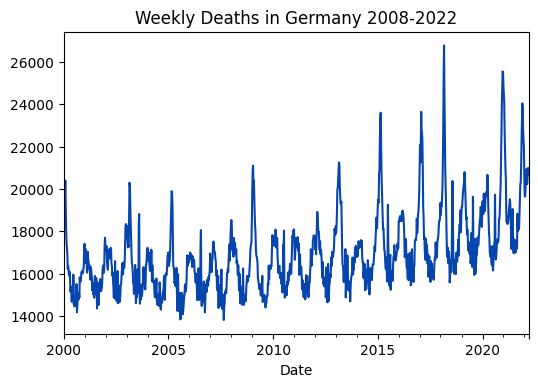

In [7]:
Weekly_Deaths.Value.plot().set_title("Weekly Deaths in Germany 2008-2022")

## 3. Analyzing seasonality
A visual inspectation of `Weekly_Deaths` gives evidence for the existence of a seasonal pattern in the mortality. In general seasonal patterns can be modeled via sine and cosine periodic functions. The mathematical theory of Fourier Analysis provides tools for finding the periodic functions that best model the seasonality of our data. The `periodogram` function from scipy is one such tool. By mapping the time series from its representation in the time domain (x-axis) to a domain (x-axis) of frequencies where peaks indicate that a sine or cosine function with the corresponding frequency models a part or the entire seasonality of the time series.

<figure>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif"/>
<figcaption style="color:white;font-size:10px;" face="Droid Sans">Visual Intuition behind the Periodogram. </figcaption>   
</center>
<figure>

In addition to the time series to be mapped, we can set the frequency domain to which it will be mapped via the argument `fs`. By setting fs to be equal to the number of weeks per year scale the frequency domain such that one year is equal to a frequency of one. For the periodogram to be accurate the time series needs to be stationary which can be achieved by detrending it beforehand. The type of trend can be set via the `detrend` argument, to us a linear trend seems to be an appropriate choice. Setting the argument `scaling` to `"spectrum"` makes sure that the following equality is fulfilled:

$$ \operatorname{Var}(X)=\int_{-\infty}^{\infty} S_{x x}(f) d f \hspace{1cm}(3.1)$$

where $X$ are the values of the time series and $f$ the frequencies returned by `periodogram`. The function $S_{x x}(f)$ is the so-called power spectrum which due to the above equation can be interpreted as the amount of variance of the times series explained by each frequency $f$. Note that due to the fact that $f$ returned by the periodogram is discrete the integration turns into summation.

In [8]:
fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
print(f"fs: {fs}\n")
f, Sxx = periodogram(Weekly_Deaths_train.Value, detrend="linear", fs=fs, scaling="spectrum")
# The Power Spectrum Sxx indicates the share of each frequency of the variance of the Time Series.
print("Is equation (3.1) fulfilled?\n")
print(f"Sxx: {np.sum(Sxx)}")
# Weekly Deaths need to be detrended because the periodogram is fitted on the detrended series.
print(f"Var: {np.var(detrend(Weekly_Deaths_train.Value))}\n")
# Peak of periodogram
print(f"Peak frequency: {f[np.argmax(Sxx)]}")

fs: 52.1775

Is equation (3.1) fulfilled?

Sxx: 2622874.1299265646
Var: 2622874.129926564

Peak frequency: 0.9999172473867595


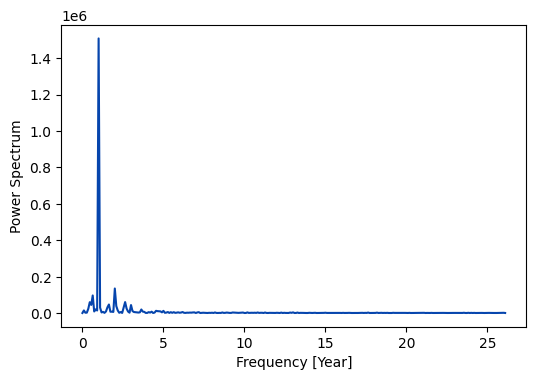

In [9]:
plt.plot(f, Sxx)
plt.xlabel('Frequency [Year]')
plt.ylabel('Power Spectrum')
plt.show()

## 4. Generating temporal Features
In this section we create features for our machine learning models. Although it would be feasible to take the entire time axis of the time series `Weekly Deaths` as feature vector this would force us to use a highly complex model because it would need to deduce seasonality and trend together from time dates alone. Due to the fact that the time series appears to have a trend and periodogram analysis in section 3 gave overwhelming evidence for yearly seasonality we decided to directly handcraft these features since this enhances the explainability of our models which is crucial in a medical context.

The function `DeterministicProcess` from statsmodels is used to generate features for each component of our time series. DeterministicProcess will generate features for the three components we use to model our time series, namely the average of the series or its *level*, its trend and its seasonality. Although DeterministicProcess has the argument `fourier`, we decide to create the periodic features ourselves via `CalendarFourier` since it enables us to control the frequency of the functions. After comparing model performance for the models using the fourier features for different values of `order` in CaldendarFourier we decided to set it to 3. This gives the model enough flexibility to adapt to the not entirerly sinosoidal shape of the peaks of the time series. Inspired by the paper by Kalinsky and Kobak (see sources) we decided to also add dummy variables for the weeks in order to have an alternative way to model the seasonal patterns in the data. The dummies are created by setting the `seasonal` argument to `True`.

In [10]:
fourierA = CalendarFourier(freq="A", order=3)


y_train = Weekly_Deaths_train.Value

dp = DeterministicProcess(index=y_train.index.to_period("W"),
                          constant=True,               # dummy feature for bias (y-intercept)
                          seasonal=True,               # Generates Dummy Variables for the Weeks (One-Hot Encoding)
                          order=2,                     # trend (order 2 means linear and quadratic)
                          additional_terms=[fourierA],) # annual seasonality (fourier)


X_train = dp.in_sample()

val_index = Weekly_Deaths_val.index
X_val = dp.out_of_sample(len(val_index), val_index)

# True values of the times series for the training and testing time frames.
y_train_true = Weekly_Deaths_train.Value
y_val_true = Weekly_Deaths_val.Value

For a more closer look at the features generated by `dp.in_sample()` run the cells below.

Text(0.5, 1.0, 'Weekly Dummies (2013-2014)')

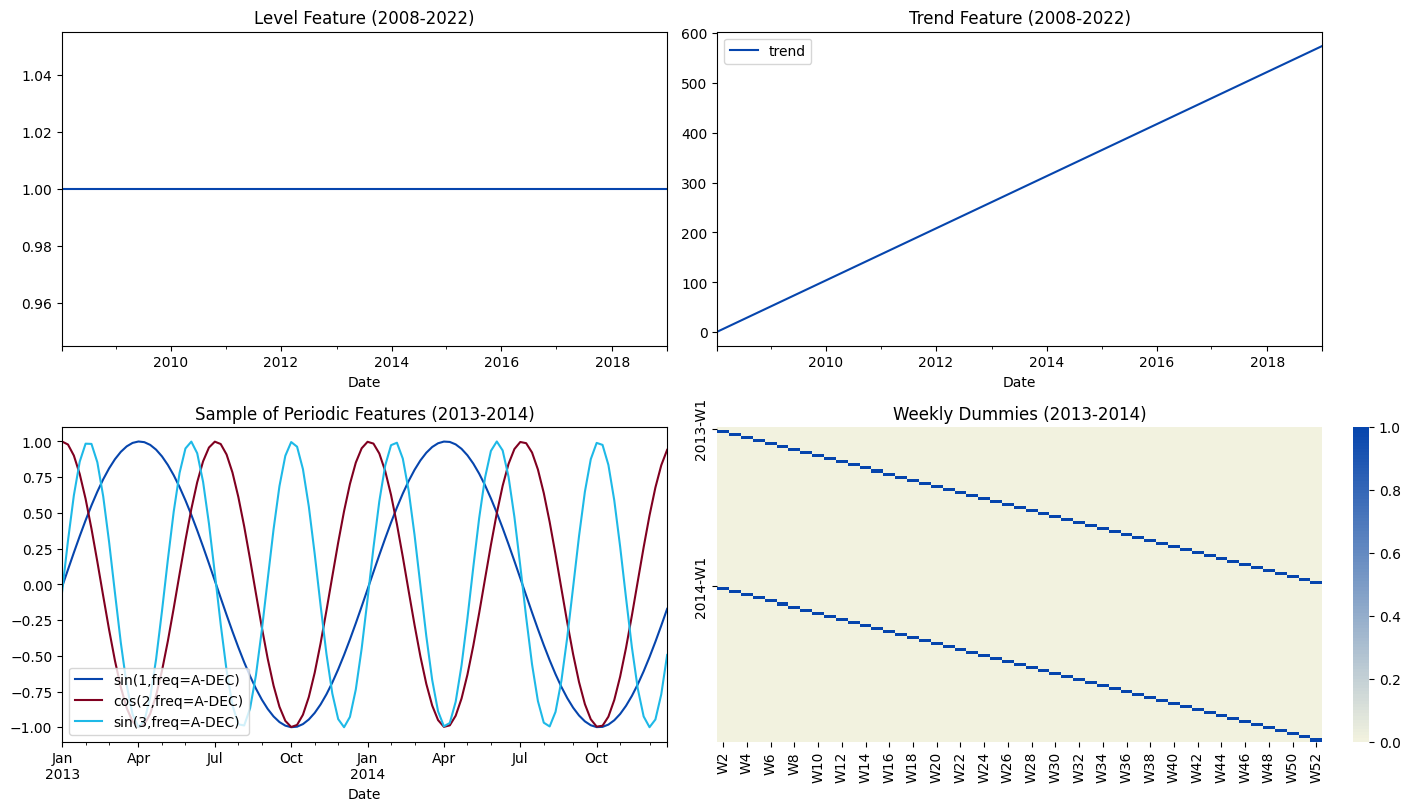

In [11]:
fig, ax = plt.subplots(2,2, layout = "constrained", figsize = (14,8))
year1 = 2013
year2 = 2014
# Level Feature
X_train["const"].plot(ax=ax[0,0]).set_title("Level Feature (2008-2022)")

# Trend Feature
X_train[["trend"]].plot(ax=ax[0,1]).set_title("Trend Feature (2008-2022)")

# Periodic Sine and Cosine Features
(X_train[["sin(1,freq=A-DEC)", "cos(2,freq=A-DEC)", "sin(3,freq=A-DEC)"]]
       .loc[X_train.index.year.isin([year1, year2])].plot(ax=ax[1,0]).set_title(f"Sample of Periodic Features ({year1}-{year2})"))
ax[1,0].legend(loc="lower left")

# One hot encoded Weeks
data = pd.DataFrame()
data[[f"W{i}" for i in range(2,53)]] = X_train[X_train.index.year.isin([year1, year2])][[f"s({i},52)" for i in range(2,53)]]
data.index = [f"{year}-W{week}" for year in [year1, year2] for week in range(1,53)]
sns.heatmap(data, ax=ax[1,1], yticklabels=52,cmap=hs_cmp).set_title("Weekly Dummies (2013-2014)")

If you also want to know how the features in `X_train` look in tabular form, then run the code below.

In [12]:
X_train.head(5)

,const,trend,trend_squared,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)",...,"s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-07/2008-01-13,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.102821,0.994700,0.204552,0.978856,0.304115,0.952635
2008-01-14/2008-01-20,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.221325,0.975200,0.431673,0.902030,0.620609,0.784120
2008-01-21/2008-01-27,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.336637,0.941634,0.633978,0.773351,0.857315,0.514793
2008-01-28/2008-02-03,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.447094,0.894487,0.799839,0.600214,0.983798,0.179281
2008-02-04/2008-02-10,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.551102,0.834438,0.919720,0.392574,0.983798,-0.179281


## 5. Fit Models
We fit and compare the performance of two models on the training data `D = (X_train, y_train)` containing the time series components as features and the Weekly Deaths until 2020 as predicted variable. In essence the models try to combine the components generated by `DeterministicProcess` in such a way that their pointwise sum looks like `y_train`. While Linear Regression is a well known technique the second algorithm we used might not be familiar to everyone. We also had to decide which loss function to use to measure the *goodness of fit* of our models and make asses the trade-off between performance and interpretability. In Addition to the two models based on all the features we train a linear regression model on only `"const"` and the `"trend"` features of `X_train` to have a simple model as benchmark.

### 5.1. Gradient Boosting
The idea behind Gradient Boosting is the stepwise combination of so called weak learners into an ensemble of models whose aggregate predictions are comparable to those of a more complex model. In our case the weak learners are *decision stumps* meaning decision trees with only one node. Gradient boosting works by calculating the gradient of the loss function after adding a new decision stump to the ensemble and then fitting a new decision stump to it, this procedure is repeated `n_estimator` of times. It can be thought of as a form of regularized gradient descent which prevents the model from overfitting by simply matching the data exactly since each decision stump is trained on the entire training data `D`. 

### 5.2. Evaluating the Models

We chose the *mean squared error* (mse) as loss function to measure the goodness of fit of our models. One advantage of the mse is that it penalizes large deviations from the true value while being lenient on small deviations. In the context of excess mortality prediction this makes sense since it isn't to important to get the number of deaths exactly right but rather to approximate them sufficiently well. For better interpretability of the performance we judge the model performance by the absolute error instead of the mse. A model that has a lower absolute error also has a lower mse. In the plot below it can be seen that `GradientBoostingRegressor` has roughly 10% lower absolute error than `LinearRegression`. It would be of interest to find a way to measure the statistical significance of such a performance improvement. It would also be interesting to try to come up with an evaluation strategy that uses more than one validation set, unfortunately the temporal structure of or data prevents us from using cross-validation for more accurate performance assesment.

### 5.3. Which Model to choose?
In the end we have to decide which model to use not only based on its performance but also based on its interpretability. Although `LinearRegression` is not alot worse than `GradientBoostingRegressor` and has a far superior interpretability, we have yet to find a scientific article that used `GradientBoostingRegressor` for excess mortality prediction. For the sake of novelty we therefore chose to calculate the excess mortality for 2020-2022 via our Gradient Boosting model.

Text(0.5, 0.98, 'Model Comparison on Weekly Deaths in Germany (Training / Validation)')

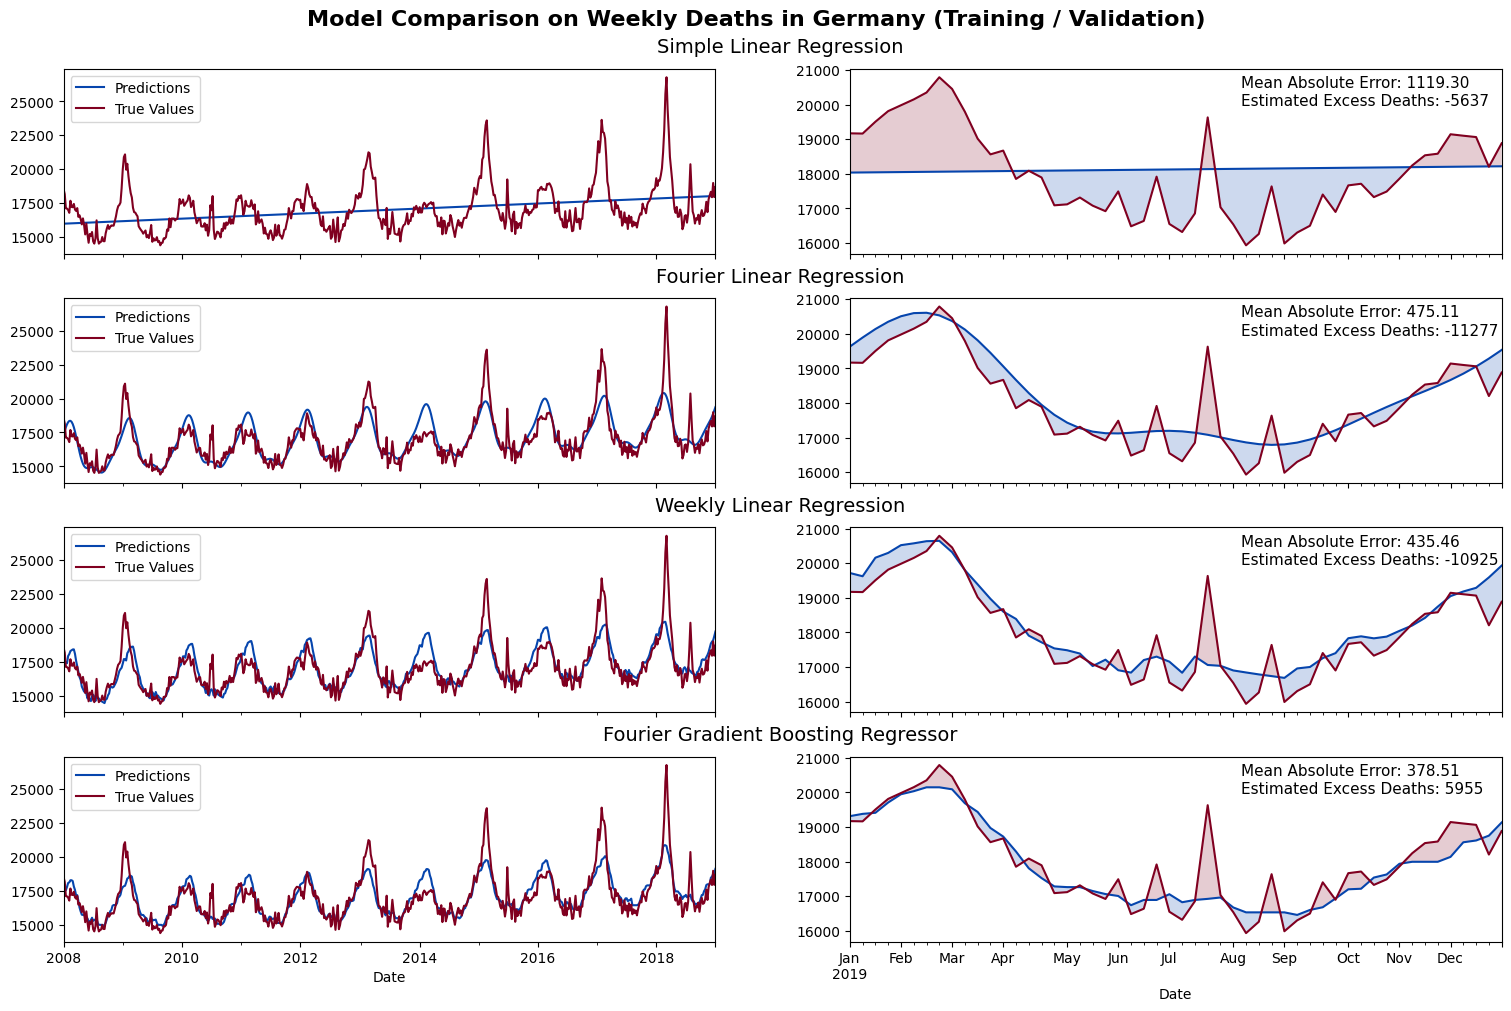

In [13]:
Models_Names = [(LinearRegression(fit_intercept=False), "Simple Linear Regression"),
                (LinearRegression(fit_intercept=False), "Fourier Linear Regression"),
                (LinearRegression(fit_intercept=False), "Weekly Linear Regression"),
                (GradientBoostingRegressor(max_depth=1, n_estimators=150), "Fourier Gradient Boosting Regressor"),
               ]

num_models = len(Models_Names)
fig, axes = plt.subplots(num_models,2,layout="constrained",sharex="col",figsize = (15,10))

for i, model_name_pair in enumerate(Models_Names):
    model = model_name_pair[0]
    model_name = model_name_pair[1]
           
    # Fit models
    if model_name == "Simple Linear Regression":
        Cols = ["const", "trend"]
    elif model_name in ["Weekly Linear Regression","Weekly Gradient Boosting Regressor"]:
        # Columns are const, trend + week dummies.
        Cols = ["const", "trend"] + [f"s({i},52)" for i in range(2,53)]
    else:
        # Columns are const, trend + fourier features.
        Cols = ["const", "trend"] + ["sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)",
                                                      "cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"]
        
    model.fit(X_train[Cols],y_train)
    
    # Make predictions and determine mean absolute error.
    y_train_pred = pd.Series(model.predict(X_train[Cols]).reshape(-1), index=y_train.index)
    y_val_pred = pd.Series(model.predict(X_val[Cols]).reshape(-1), index=val_index)
    mean_abs_err = np.mean(abs(y_val_true - y_val_pred))
    sum_blue_red_area = np.sum(y_val_true - y_val_pred)
    
    ax_train = axes[i,0]
    ax_train.set_title(f"{model_name}", y=1.05,x=1.1, pad=5, size=14)
    y_train_pred.plot(ax=ax_train, label="Predictions")
    y_train_true.plot(ax=ax_train, label="True Values")
    ax_train.legend()
    
    # Plot results for the validation set.
    ax_val = axes[i,1]
    y_val_pred.plot(ax=ax_val)
    y_val_true.plot(ax=ax_val)
    ax_val.axes.annotate(f"Mean Absolute Error: {mean_abs_err:.2f}", xy=(0.6,0.9), xycoords='axes fraction', fontsize=11)
    ax_val.axes.annotate(f"Estimated Excess Deaths: {sum_blue_red_area:.0f}", xy=(0.6,0.8), xycoords='axes fraction', fontsize=11)
    ax_val.fill_between(y_val_true.index,y1=y_val_true , y2=y_val_pred, where=y_val_true <= y_val_pred, facecolor='#0645ad', alpha=0.2,interpolate=True)
    ax_val.fill_between(y_val_true.index,y1=y_val_true , y2=y_val_pred, where=y_val_true >= y_val_pred, facecolor='#800020', alpha=0.2,interpolate=True)

plt.suptitle("Model Comparison on Weekly Deaths in Germany (Training / Validation)", fontsize="16",fontweight="bold")  
#plt.savefig("Comparison of Linear Regression Models.png", dpi = 200)

## 6. Analyze Residuals of Gradient Boosting Model
The term *residual* describes the difference between the value of the time series at a time step $t$ and the prediction of the model for that time step.

$$ \text{residuals}(t) = \text{TimeSeries}(t) - \text{Predictions}(t)\hspace{1cm}(6.1)$$

### 6.1. Partial Autocorrelation
We have already looked at the mean squared error and absolute error in the preceding section, so why is this quantity still of interest? It turns out that for modeling confidence intervals, we need the residuals to be uncorrelated. This isn't the case unfortunately, which we can show by generating the *partial autocorrelation* plot of the residuals. Before we explain what the partial autocorrelation is, let's look at the *autocovariance* first. For our time series of residuals `residuals` the autocorrelation is defined based on the autocovariance function $r$.

$$ r(s) = \text{Cov}(\text{residual}(t), \text{residual}(t-s))\hspace{0.5cm}{\forall} s,t\in\mathbb{N}\hspace{1cm}(6.2)$$

The function $r(s)$ let's us calculate the covariance of the time series at time step $t$ with itself at time step $t-s$ or lag $s$.  Note that $r( )$ doesn't depend on $t$ so we assume that the autocovariance only depends on the number of timesteps between the two arguments of the function and not the specific value of $t$. Based on this definition, the autocorrelation can be defined as 

$$\rho(s) = \dfrac{r_s}{r_0}\hspace{1cm}(6.3)$$

Now the problem with this function is that the autocorrelation between the time series and its $s$-th lag might be influenced by all the lags in between from one to $s-1$. This is where the partial autocorrelation comes into play which is calculated by isolating the direct influence lag $s$ has on the time series from its influence via the other lags in between. Plotting and calculating the partial autocorrelation or *pacf* can be done in Python via the `plot_pacf` function from the `statsmodels` library. The partial autocorrelations are calculated via an approach based on (ordinary) linear regression, which for conciseness we won't further discuss here.

### 6.2. Analyzing the Residuals.
Since the correlation implies dependence, we can't use techniques such as *kernel density estimation* to get an estimation of the probability density function which generates the residuals. We can still however use histograms to get an idea of the statistical properties of the residuals. Our histogram plot shows that the residuals are centered around zero, which suggests that our model has correctly inferred the underlying level and trend of the time series properly.

Looking at the distributions of the bins of the histograms shows a strong deviation from symmetry due to a long tail of positive values. This means that our residuals are most likely not normally distributed, hence many theoretical results and guarantees won't apply to our model. 

Text(0.5, 0.98, 'Analysis of Residuals for Gradient Boosting Model')

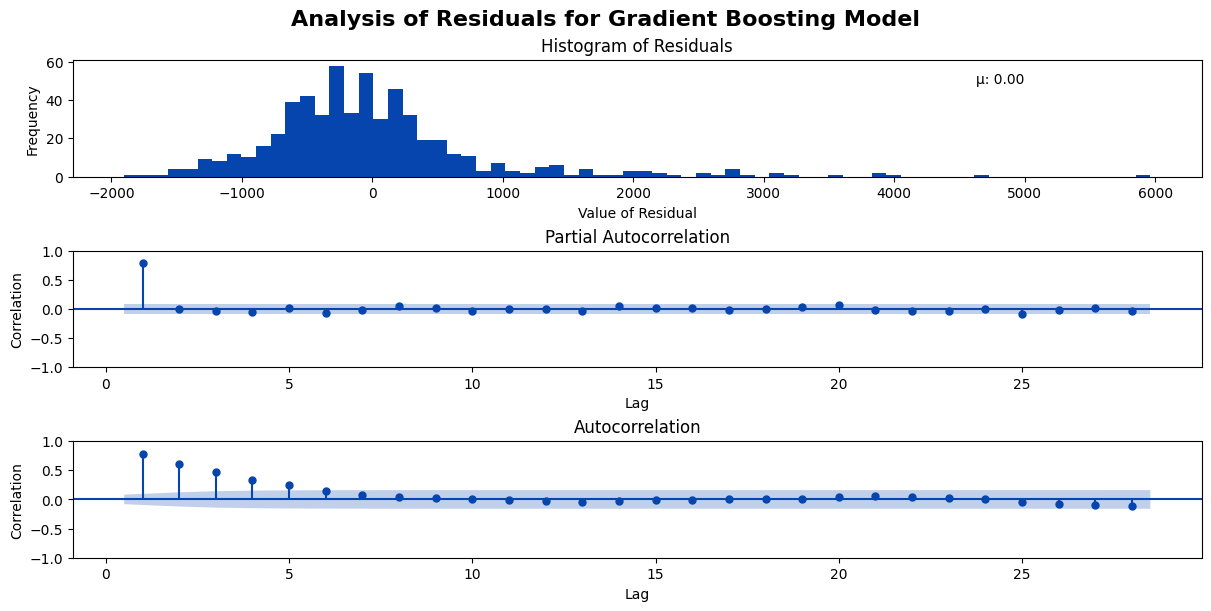

In [14]:
#%% Analyze Residuals.
residuals = Weekly_Deaths_train.Value - y_train_pred # Residuals (see 6.1)
# Prepare plot.
fig, ax = plt.subplots(3,1, layout="constrained", figsize=(12,6))
ax[0].axes.annotate(f"μ: {residuals.mean():.2f}", xy=(0.8,0.8), xycoords='axes fraction', fontsize=10)
ax[0].set_xlabel("Value of Residual")
ax[1].set_ylabel("Correlation")
ax[1].set_xlabel("Lag")
ax[2].set_ylabel("Correlation")
ax[2].set_xlabel("Lag")
# Plot pacf and residual histogram.
plot_pacf(residuals, ax=ax[1], method='ols', zero=False)  
plot_acf(residuals, ax=ax[2], zero=False)  
residuals.plot(ax=ax[0], kind="hist", bins=70).set_title("Histogram of Residuals")
plt.suptitle("Analysis of Residuals for Gradient Boosting Model", fontsize="16",fontweight="bold") 
#plt.savefig("AnalysisResiduals.png", dpi=200)

### 6.3. Conclusion
Since our residuals are correlated, there seems to be some information in the data that our model hasn't captured. This means that there is room for improvement for our predictions. In order to harness the correlation of the time series with its lags, we looked into the theory of time series, specifically AR and SARIMA processes, in order to build a new model that can incorporate autocorrelations of the time series. Getting rid of the correlation will also enable us to generate sensible confidence intervals for our predictions. The following points summarize the content of this section:

<span style="color:grey;font-weight:500;font-size:12px">
<ul style="line-height:200%">
  <li>Residuals are the difference between the true values of a time series and their predictions by the model.</li>  
  <li>The partial autocorrelation describes the correlation between a time series and its lags, accounting for the    correlations between the lags themselves.</li>
  <li>The histogram indicates an asymmetric distribution of the residuals centered around zero.</li>  
  <li>The model doesn't capture all the information available in the data due to remaining correlation. </li>
</ul>
</span>

## 7. Fitting a SARIMA Model.

### 7.1. The ARMA Model.
Autocorrelation and by extenstion partial autocorrelation can be caused by two types of dependencies. In order to understand what kind of dependencies these are let's first mathematically define what a Time Series is. Leaving seasonality and trend aside a Time series with discrete time steps can be represented as the sum of two types of series of random Variables $\{X_t,t\in\mathbb{Z}\}$ also called stochastic processes. The first type of stochastic process involved is called a *Moving Average Process* where the $X_t$ depend on each other in the following way

#### Definition 7.1.1
A stochastic process $\left\{X_{t}, t \in \mathbb{Z}\right\}$ is said to be a Moving Average of order $q \geq 0$ or $\mathrm{MA}(q)$ if
$$
X_{t}=\sum_{k=1}^{q} \nu_{k} \varepsilon_{t-k}+\varepsilon_{t}\quad , \nu_{q} \neq 0
$$
with $\left\{\varepsilon_{t}, t \in \mathbb{Z}\right\}$ white noise and $\nu_k\in\mathbb{R}$.

The term *White Noise* refers to uncorrelated random Variables with finite variance. In essence the $X_t$ of a moving average process is generated by the sum of random variables taken from a white noise process which means that they depend on $X_{t-1}$ via the shared $\varepsilon$ terms in both sums. The other type of stochastic process underlying a trendless or *stationary* and seasonless time series is called *Autoregressive Process* where the $X_t$'s depend directly on each other.

#### Definition 7.1.2
A stochastic process $\left\{X_{t}, t \in \mathbb{Z}\right\}$ is called autoregressive of order $p \geq 1$ or $\mathrm{AR}(p)$ if
$$
X_{t}=\sum_{k=1}^{p} \alpha_{k} X_{t-k}+\varepsilon_{t}, \quad, \alpha_{p} \neq 0
$$
$\left\{\varepsilon_{t}, t \in \mathbb{Z}\right\}$ white noise and $\alpha_k\in\mathbb{R}$.

Note that in both terms there is an error term $\varepsilon_t$ being added. This implies that the dependence of $X_t$ on the sum is not deterministic. In (7.1.2) $X_t$ depends directly on it's predecessors and can be written as a linear combination of them. Now these to processes can be combined into a so called *ARMA process* where *AR* stands for the autoregressive part and *MA* for the moving average part.

#### Definition 7.1.3
A stochastic process $\left\{X_{t}, t \in \mathbb{Z}\right\}$ is said to be an autoregressive Moving Average of order $(p, q)$ or $\operatorname{ARMA}(p, q)$ if
$$
X_{t}=\sum_{k=1}^{p} \alpha_{k} X_{t-k}+\sum_{k=1}^{q} \nu_{k} \varepsilon_{t-k}+\varepsilon_{t}
$$
with $\left\{\varepsilon_{t}, t \in \mathbb{Z}\right\}$ white noise.

There are algorithms related to Linear Regression with which the coefficients for the MA and AR part of a time series and the variance of the white noise can be estimated. The estimated coefficients can then be used to make predictions for future values ot the time series $X_{t+1}, X_{t+2}, ...$

### 7.2. The ARIMA Model.
Often time series aren't stationary because of the presence of a so-called trend. This means that there is a deterministic function of the time $f(t)$ , such that the expected value of the $X_t$'s isn't constant anymore, as is the case for stationary time series, but rather given by $T(t)$. As an example we can think of an ARMA(p,q) model to which a trend being given by $T(t) = a + bt$ has been added. The result is then called *ARIMA* process whereby the "*I*" stands for *integrated*.

Consider the following example: Let $X_{t}=T(t)+R_{t}$ be a process with linear trend $T(t)=a+b t$ and stationary rest $\left\{R_{t}: t \in \mathbb{Z}\right\}$. Then
$$
\nabla (X_{t})=X_{t}-X_{t-1}=a+b t+R_{t}-a-b(t-1)-R_{t-1}=b+R_{t}-R_{t-1}
$$

For trends of higher polynomial order such as $T(t)=a+bt+ct^2$ applying the difference operator two times will get rid of the trend. In general a polynomial trend of order $d$ can be removed by applying $\nabla(X_t)$ d-times. For non-polynomial trends you can still get a good approximation with this method since polynomials can approximate most functions reasonably well over constrained intervals.

#### Definition 7.2.1
Consider $p, d, q \geq 0 . \quad\left\{X_{t}, t \in \mathbb{Z}\right\}$ is called an autoregressive integrated moving averageprocess of order $(p, d, q) or \operatorname{ARIMA}(p, d, q)$ if
$$
\nabla^d (X_{t})
$$
is a stationary $\operatorname{ARMA}(p, q)$-process.

For an $ARIMA(p,1,q)$-process we can get the first observation $X_0$ ro reestablish the process from the corresponding $ARMA(p,q)$ model.

$$X_{t}=X_{0}+\sum_{j=1}^{t} Y_{j}\hspace{1cm} (7.2.1)$$

where $Y_t=X_t-X_{t-1}$.

In case of $d=1$, Inference of future values can be made by using the last known value $X_n$ instead of $X_0$ and using the algorithmically generated coefficients $\alpha$ and $\nu$ to calculate $\hat{X}_{n+1}$ and then use this estimate in addition to $X_n$ to calculate $\hat{X}_{n+2}$ and so on. Note that we need to put a hat "^" onto $X_t$ with $t>n$ since those are estimates of unobserved values. Equation (7.2.1) gives an intuition as to why time series with a trend are called "integrated". The term "integration" refers to the inverse operation of "differentiation" in Analysis. Since We reestablish the trend by undoing the application of the difference operator $\nabla$ to our time series we can loosely think of this process as performing "integration".

Note that trend removal doesn't get rid of the constant term $a$ of $T(t)$. The algorithms from the Python module `statsmodels` used in this notebook assume that the data is zero centered, meaning that this has to be taken into account by subtracting the mean of the data before applying any model from the module.

### 7.3. The SARIMA Model.

Now assume that the data displays seasonal variations.  This means that there is a regular periodic change in the mean of the series such that for instance the temperatures in June are generally higher than those in December. Additionaly we also assume that the series was already detrended, which is necesarry for deaseasoning to work. The same idea that we used to get rid of the trend can also be used to get rid of the seasonality of the time series.  In order to get a better intuition for how we are going to do this take a look at the table below containing the entries of a time series 

$$
\begin{array}{cc|llllll} 
& & 1 & 2 & 3 & \ldots & 52 & \text { Week } \\
\hline \text { Year } & 1 & X_{1} & X_{2} & X_{3} & \ldots & X_{52} & \\
& 2 & X_{53} & X_{14} & \ldots & \ldots & X_{104} & \\
& 3 & X_{105} & X_{106} & \ldots & \cdots & X_{156} & \\
& 4 & X_{157} & \ldots & \cdots & \cdots & X_{208} & \\
& \vdots & \vdots & & & &
\end{array}
$$

Instead of writing the observed values of the time series as a list we can also put them into a table where we can interpret seasonality as the dependence of the entries in each column on the entries in the preciding rows of the same column. In the table above the rows represent the year and columns the week of the year. We can think about the seasonality as the dependence of each week in a given year on the same week in the preceeding years. We can then try to model this dependence as an ARMA(P,Q) model given by

$$X_{t}=\sum_{k=1}^{P} \rho_{k} X_{t-52 k}+\sum_{k=1}^{Q} \gamma_{k} V_{t-52 k}+V_{t}$$

where for a given week $w = t \text{ mod } 52$  $\left\{V_{w-52k}, k \in \mathbb{Z}\right\} $is white noise. We didn't use the symbol $\varepsilon$ for the white noise here because in general $V_{t_a}$ and $V_{t_b}$ can be correlated if $t_a \neq t_b +52$ for some $k$. We just assume that on a seasonal basis, which means on a yearly basis in case of the table, $V_t$ behaves like white noise.

This is exactly what packages such as `statsmodels` do when handling seasonal variation. The intraseasonal dependence of the time series, meaning the dependence of each week on the preceeding weeks can then also be modeled by an ARMA(p,q)-process. Both models can then be added to get the combined model that takes into account both seasonal and weekly dependence. The resulting model is a $ARMA(p+Ps, q+Qs)$ process. Note that not all indices $k_{AR}=1,...,p+Ps$ and $k_{MA}=1,...,q+Qs$ correspond to non-zero coefficients. The $s$ stands for the length of a season.

The general notation for a SARIMA model, allowing for a trend in addition to seasonality, is given by $SARIMA(p,d,q)\times(P,D,Q)_s$ where $d,D$ indicate the trends for the time series as a whole and between each season respectively. Trends can be "differenced away" by repreated application of the $\nabla$ operator. We gave an intuition as to how to model a SARIMA-process based on an ARMA process for which forecasting algorithms exist. 

There are criteria with whom we can judge what orders for the AR and MA components to choose. Since this is already a math heavy section we won't dive into to much detail. We choose the coefficients for our model based on performance on the validation set containing the weekly deaths for 2019 in Germany. Note that the `statsmodels` implementation for fitting a SARIMA model is called `SARIMAX` with the additional `X` standing for *exogenous*. This describes data that can be used in addition to the temporal structure of the time series to explain its values. One example would be a data set that includes the dates on which temperatures where above 40 degrees.


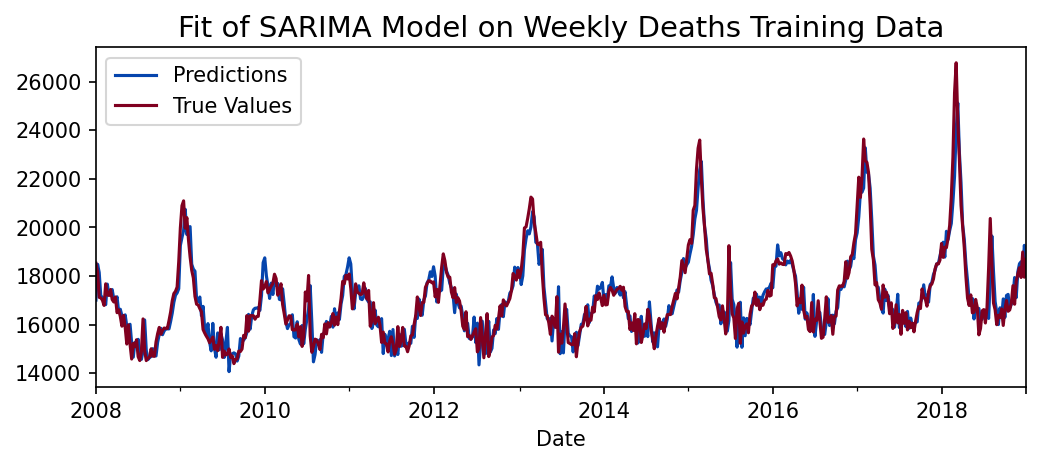

In [15]:
y = Weekly_Deaths_train.Value
# series has to be zero centered for training to work properly.
y_train = pd.Series(y - y.mean(), index=Weekly_Deaths_train.index)
# order = (p,d,q) , seasonal_order=(P,D,Q,s) 
model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,52))
model_fit = model.fit()
Preds = pd.Series(model_fit.predict(), index=y_train.index)


# Make Plot.
fig, ax = plt.subplots(dpi=150, figsize=(8,3))
Preds.add(y.mean()).plot(ax=ax, label="Predictions")
y.plot(ax=ax, label="True Values")
ax.legend(loc="upper left")
ax.set_title("Fit of SARIMA Model on Weekly Deaths Training Data", pad=5, size=14) 
plt.savefig("Fit of SARIMA Model on Training Data.png", dpi=200)

### 7.4. Analyzing the Residuals
The most important argument for putting in all this work into researching and applying a SARIMA model was that our previous models were not able to use all the information contained in the data as shown by the significant autocorrelation of the residuals. Our residual analysis now shows that the SARIMA model fits the data well enough to get rid of any significant autocorrelation. This also enables us to provide confidence intervals for the model predictions. We can now also use *Kernel Density Estimation* to get an approximate distribution of the residuals and compare it to the normal distribution. As seen in the second subplot the distribution seems to be well approximated by a normal distribution which yields further advantages when generating the confidence intervals.

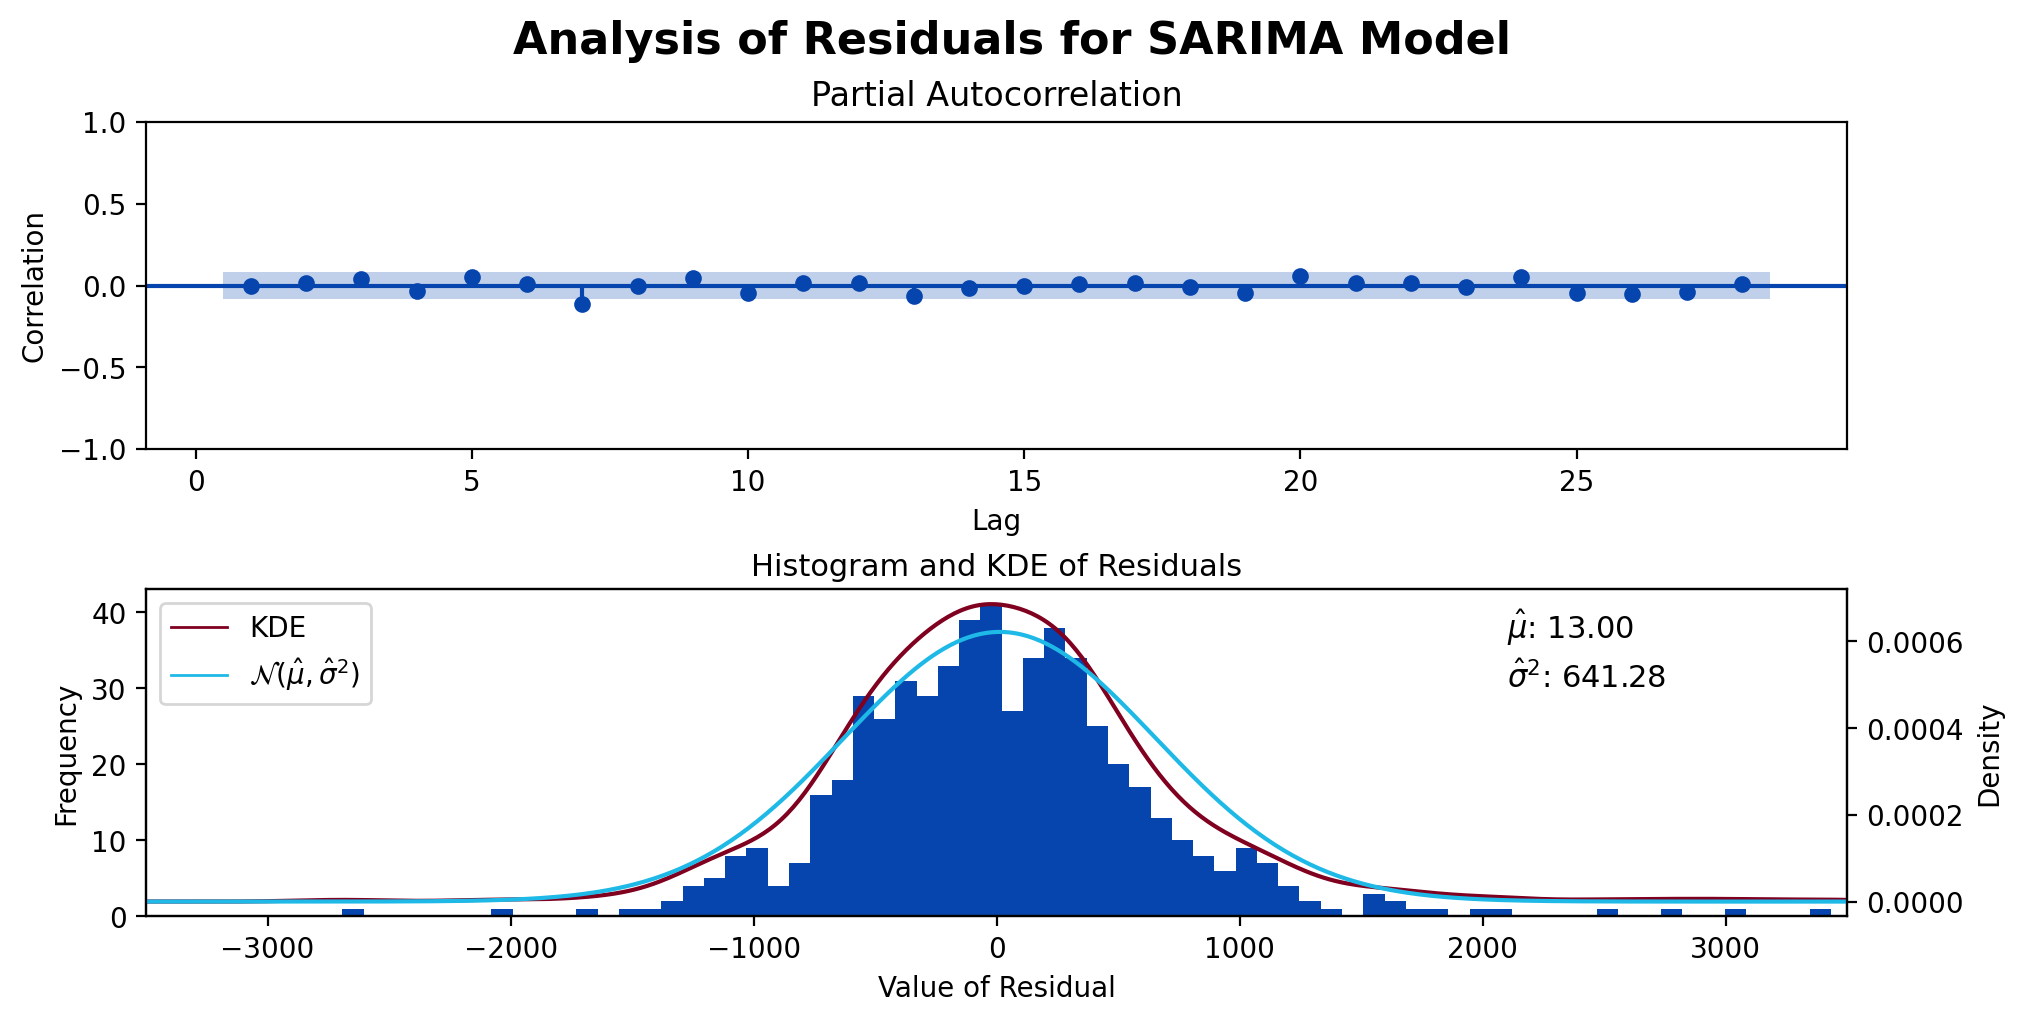

In [16]:
residuals = y_train - Preds

# Make Plots.
fig, ax = plt.subplots(2,1,layout="constrained", figsize=(10,5), dpi=200)
plot_pacf(residuals, ax=ax[0], method='ols', zero=False) 
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Correlation")
# Calculate and annotate the second subplot with the mean and standard deviation of `residuals`.
mu = np.mean(residuals)
sigma = np.std(residuals)
ax[1].axes.annotate("$\hat{\mu}$" + f": {mu:.2f}", xy=(0.8,0.85), xycoords='axes fraction', fontsize=11)
ax[1].axes.annotate("$\hat{\sigma}^2$" + f": {sigma:.2f}", xy=(0.8,0.7), xycoords='axes fraction', fontsize=11)
# Plot Histogram and Kernel Density Estimation of `residuals`. 
residuals.plot(ax=ax[1], kind="hist", bins=70)
residuals.plot(ax=ax[1], kind="kde", secondary_y=True) # Rememeber that the Scale of the KDE and Histogram Plot are different.
# Plot a Normal Distribution with the same mean and standard deviation that of the residuals.
xlim_a, xlim_b = -3500, 3500 # Values of residuals are within (-3500, 3500).
ax[1].set_xlim(xlim_a, xlim_b)
X = np.linspace(xlim_a, xlim_b, len(y_train))
normal_dist = pd.Series(stats.norm.pdf(X,mu,sigma), index = X)
normal_dist.plot(ax=ax[1], secondary_y=True)
ax[1].set_title(f"Histogram and KDE of Residuals",pad=5, size=11)
ax[1].set_xlabel("Value of Residual")
ax[1].set_ylabel("Frequency")
ax[1].right_ax.set_ylabel("Density")

# custom legend
custom_lines = [mpl.lines.Line2D([0], [0], color="#800020", lw=1),
                mpl.lines.Line2D([0], [0], color="#1EB9E7", lw=1)]
ax[1].legend(custom_lines, ["KDE","$\mathcal{N}(\hat{\mu},\hat{\sigma}^2)$"], loc='upper left')

plt.suptitle("Analysis of Residuals for SARIMA Model", fontsize="16",fontweight="bold") 
plt.savefig("Analysis of Residuals for SARIMA.png", dpi=200)

### 7.5. Validation of Model Performance
We now test the performance of our fitted SARIMA model against the validation data set containing the Weekly Deaths in Germany in 2019. The mean absolute error of the model is a tick worse than that of the Gradient Boosting Regressor model ($379.78$ vs. $378.51$ respectively). Due to the fact that we only undertook validation on one data set this might as well be noise and no indication of superiority of Gradient Boosting. One factor that might have impacted model performance is the presence of a 53 week in some years which could lead to a shift of the seasonal pattern over time, negatively impacting performance. We will need to look into this matter more closely.

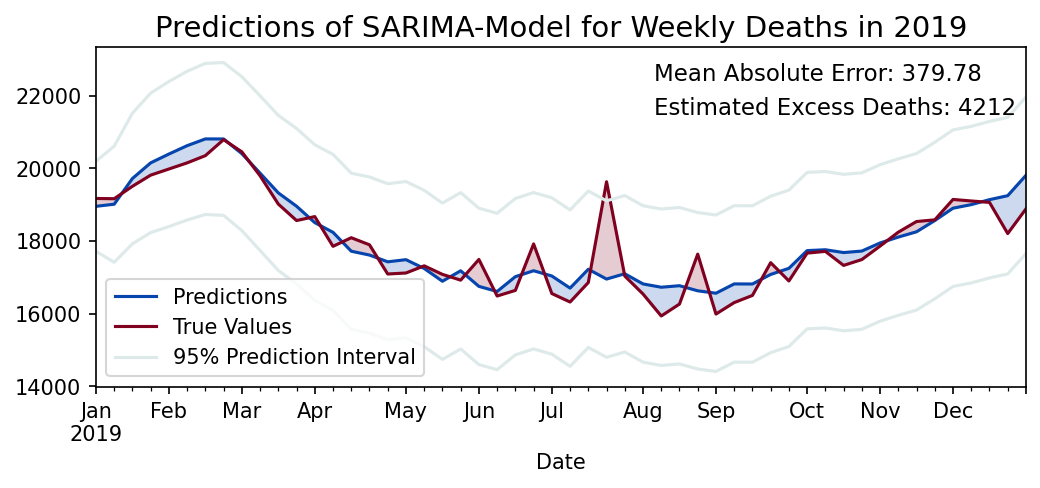

In [17]:
y_mean = y.mean()

y_pred = model_fit.get_forecast(52)
y_pred_mean = y_pred.predicted_mean.add(y_mean)
y_pred_lower_bound = y_pred.conf_int()["lower Value"].add(y_mean)
y_pred_upper_bound = y_pred.conf_int()["upper Value"].add(y_mean)

y_val = Weekly_Deaths_val.Value

mean_abs_err = np.mean(abs(y_pred_mean - y_val))
sum_blue_red_area = np.sum(y_pred_mean - y_val)

# Make Plot.
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
y_pred_mean.plot(ax=ax, label="Predictions")
y_val.plot(ax=ax, label="True Values")
y_pred_lower_bound.plot(ax=ax, c="#DDEAE9", label="95% Prediction Interval")
y_pred_upper_bound.plot(ax=ax, c="#DDEAE9", label="")

ax.set_title("Predictions of SARIMA-Model for Weekly Deaths in 2019", pad=5, size=14) 
ax.axes.annotate(f"Mean Absolute Error: {mean_abs_err:.2f}", xy=(0.6,0.9), xycoords='axes fraction', fontsize=11)
ax.axes.annotate(f"Estimated Excess Deaths: {sum_blue_red_area:.0f}", xy=(0.6,0.8), xycoords='axes fraction', fontsize=11)
ax.fill_between(y_val.index, y1=y_val , y2=y_pred_mean, where=y_val <= y_pred_mean, facecolor='#0645ad', alpha=0.2,interpolate=True)
ax.fill_between(y_val.index, y1=y_val , y2=y_pred_mean, where=y_val >= y_pred_mean, facecolor='#800020', alpha=0.2,interpolate=True)
ax.legend(loc="lower left")
plt.savefig("Validation of SARIMA model.png", dpi=200)

### 7.6. Conclusion

<span style="color:grey;font-weight:500;font-size:12px">
<ul style="line-height:200%">
  <li>ARMA processes can model time series by expressing it in terms of dependence on previous values and error terms.</li> 
  <li>A trend of order $d$ in a time series can be removed by taking the difference between timesteps $d$ times. </li>
  <li>The SARIMA model further takes into account the presence of a trend and seasonality in a time series.</li>
  <li>Our fitted SARIMA model get's rid of significant autocorrelation between the residuals, paving the way for generating confidence intervals.</li>  
  <li>The performance of the SARIMA model is competitive with Gradient Boosting. </li>
</ul>
</span>

## 8. Large Scale comparrison of SARIMA-Model and Gradient Boosting.

The SARIMA model and Gradient Boosting yield similar results on the 2019 validation set, therefore we have no evidence that one model is better than the other except for the fact that the SARIMA model fits the data such that the residuals aren't autocorrelated. We attempt to measure model performance more precisely by iteratively using 11 years of training data and one year of validation data until starting from 2000 to measure the model performance on multiple validation sets. The approach taken in this section is similar to cross-validation. which can't be applied here due to the temporal order to the data i.e only previous years can be used to predict the validation data for a given year.

### 8.1. Model Evaluation.
The code below can be used to compare the performance of an arbitrary amount of models on the `Weekly_Deaths` and `Weekly_Deaths_Standardized` dataset. The performance metrics measures are the mean absolute error *MAE* and the estimated excess deaths *EED* in percent of total deaths in a given year. The number of years used for training `train_years` as well as for validation `val_years` can be set by the user. The number of times the models can be trained and compared is then calculated in `num_runs`. Setting `train_years = 11` and `val_years = 1` results in comparable average MAE values (Gradient Boosting Regressor: 671.99, SARIMA: 668.58) on the weekly deaths dataset as well as on the age standardized weekly deaths dataset (Gradient Boosting Regressor: 0.9, SARIMA: 0.9).

In [ ]:
# Below models are fitted on features generated by DeterministicProcess
Feature_Models = [(LinearRegression(fit_intercept=False), "Simple Linear Regression"),
                  (LinearRegression(fit_intercept=False), "Squared Linear Regression"),
                  (GradientBoostingRegressor(max_depth=2, n_estimators=150), "Gradient Boosting Regressor"),
                  (SARIMAX([], order=(1,1,1), seasonal_order=(1,1,1,52)), "SARIMA")
                 ]                                                      

Datasets = [({"Simple Linear Regression": [],
              "Squared Linear Regression": [],
              "Gradient Boosting Regressor": [],    
              "SARIMA": [],                        # Mean absolute errors
             },
             
             {"Simple Linear Regression": [],
              "Squared Linear Regression": [],
              "Gradient Boosting Regressor": [],   
              "SARIMA": [],
             },                                    # Estimated excess deaths.
              Weekly_Deaths, "Weekly Deaths"),
    
            ({"Simple Linear Regression": [],
              "Squared Linear Regression": [],
              "Gradient Boosting Regressor": [],
              "SARIMA": [],
             },
             
             {"Simple Linear Regression": [],
              "Squared Linear Regression": [],
              "Gradient Boosting Regressor": [],
              "SARIMA": [],
             },
              Weekly_Deaths_standardized,"Weekly Deaths Standardized")]

# Number of years used for training and validation.
train_years = 11
val_years = 1
start_year = 2000

# Total number of years covered by Weekly_Deaths. Same for Weekly_Deaths_standardized.
num_years_total = len(Weekly_Deaths[Weekly_Deaths.index.year < 2020].index.year.unique())
# Number of times models can be trained on 10 years of previous data and one year of validation data.
num_runs = num_years_total - val_years - train_years + 1

for year in range(start_year, start_year + num_runs):
    for model_dict_MAE, model_dict_EED, dataset, _ in Datasets:
        
        train_data = dataset[(dataset.index.year >= year) & (dataset.index.year < year + train_years)].Value
        val_data = dataset[(dataset.index
                                   .year
                                   .isin([year + train_years + step for step in range(0,val_years)]))].Value
        
        dp = DeterministicProcess(index=train_data.index.to_period("W"),
                                  constant=True,                # dummy feature for bias (y-intercept)
                                  seasonal=True,                # Generates Dummy Variables for the Weeks (One-Hot Encoding)
                                  order=2,                      # trend (order 2 means linear and quadratic)
                                  additional_terms=[fourierA],) # annual seasonality (fourier) (see section 4)
        
        X_train = dp.in_sample()
        X_val = dp.out_of_sample(len(val_data.index), val_data.index)
               
        for model, model_name in Feature_Models:

            # Fit models  
            
            if model_name == "Simple Linear Regression":
                Cols = ["const", "trend"]
            
            if model_name == "Squared Linear Regression":
                Cols = ["const", "trend", "trend_squared"]
                
            if model_name == "Gradient Boosting Regressor":
                # Columns are const, trend + fourier features.
                Cols = ["const", "trend"] + ["sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)",
                                             "cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"]
                
            if model_name == "SARIMA":
                model = model.clone(train_data - train_data.mean()) 
                model_fit = model.fit()
                val_preds = model_fit.get_forecast(52)
                val_preds = val_preds.predicted_mean.add(train_data.mean())
                
            else:
                model.fit(X_train[Cols], train_data)
                val_preds = pd.Series(model.predict(X_val[Cols]).reshape(-1), index=val_data.index)
            
            mean_abs_err = np.mean(abs(val_data - val_preds))
            est_exc_deaths_p = np.sum(val_data) - np.sum(val_preds)
            
            model_dict_MAE[model_name].append({f"{model_name}": mean_abs_err})
            model_dict_EED[model_name].append({f"{model_name}": est_exc_deaths_p})

### 8.2. Visualization.

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10), layout="constrained", sharex="col", dpi=100)

index = pd.Index([year + start_year + train_years for year in range(num_runs)])
i = 0
for model_dict_MAE, model_dict_EED, _, dataset_name in Datasets:
    # Generate data for mean absolute error and excess estimated deaths in percent
    MAE = pd.concat([pd.DataFrame(data=model_dict_MAE[model_name], index=index) for _, model_name in Feature_Models], axis=1)
    EED = pd.concat([pd.DataFrame(data=model_dict_EED[model_name], index=index) for _, model_name in Feature_Models], axis=1)
    
    # Plots for mean absolute error (first column of fig).   
    MAE.plot(ax=axes[i,0], kind="bar", rot=0)
    
    model_names = list(model_dict_MAE.keys())
    model_abbrv = [''.join(c for c in name if c.isupper()) for name in model_names]
    
    annot0 = "".join([f"$μ_{{{model_abbrv[i]}}}$: {MAE[model_names[i]].mean():.2f}\n" for i,_ in enumerate(model_names)])
    axes[i,0].axes.annotate(annot0, xy=(0.03,0.75), xycoords='axes fraction', fontsize=10)
    
    axes[i,0].get_legend().remove()
    if i == 1:
        axes[i,0].set_ylabel("[Per 100'000]") 
        
    # Plots for estimated excess deaths (second column of fig).    
    EED.plot(ax=axes[i,1], kind="bar", rot=0)
    
    annot1 = "".join([f"$|μ_{{{model_abbrv[i]}}}$|: {EED[model_names[i]].abs().mean():.2f}\n" for i,_ in enumerate(model_names)])
    axes[i,1].axes.annotate(annot1, xy=(0.03,0.75), xycoords='axes fraction', fontsize=10)
    axes[i,1].set_xlabel("Date")
    axes[i,1].set_ylabel("")
    axes[i,1].legend(loc="upper right")
    
    # Rowtitle: Weekly Deaths first row and Weekly Standardized Deaths second row.
    axes[i,0].set_title(f"{dataset_name}", y=1.05,x=1.1, pad=5, size=14)
    i += 1
    
# Last year used for validations
last_val_year = start_year + num_runs + train_years - 1
plt.suptitle(f"Comparison of Model Predictions for {start_year+train_years}-{last_val_year}\n(Mean Absolute Error/ Estimated Excess Deaths)",
             fontsize="16",fontweight="bold")  
#plt.savefig(f"ModelLongComparison{train_years}.png", dpi = 200)

## 9. Excess Mortality Estimation
We now use our Gradient Boosting model to estimate the number of excess deaths between the start of 2020 and March 2022 in Germany. Our model estimates roughly $131000$ excess deaths in comparisson to two "normal" years with winterly influenza waves. In addition we apply the model to the age standardized version of the dataset yielding an estimated $23$ excess deaths per week in 2020. 

### 9.1. Applying Gradient Boosting Model

Text(0.5, 0.98, 'Model: Gradient Boosting with Fourier Features')

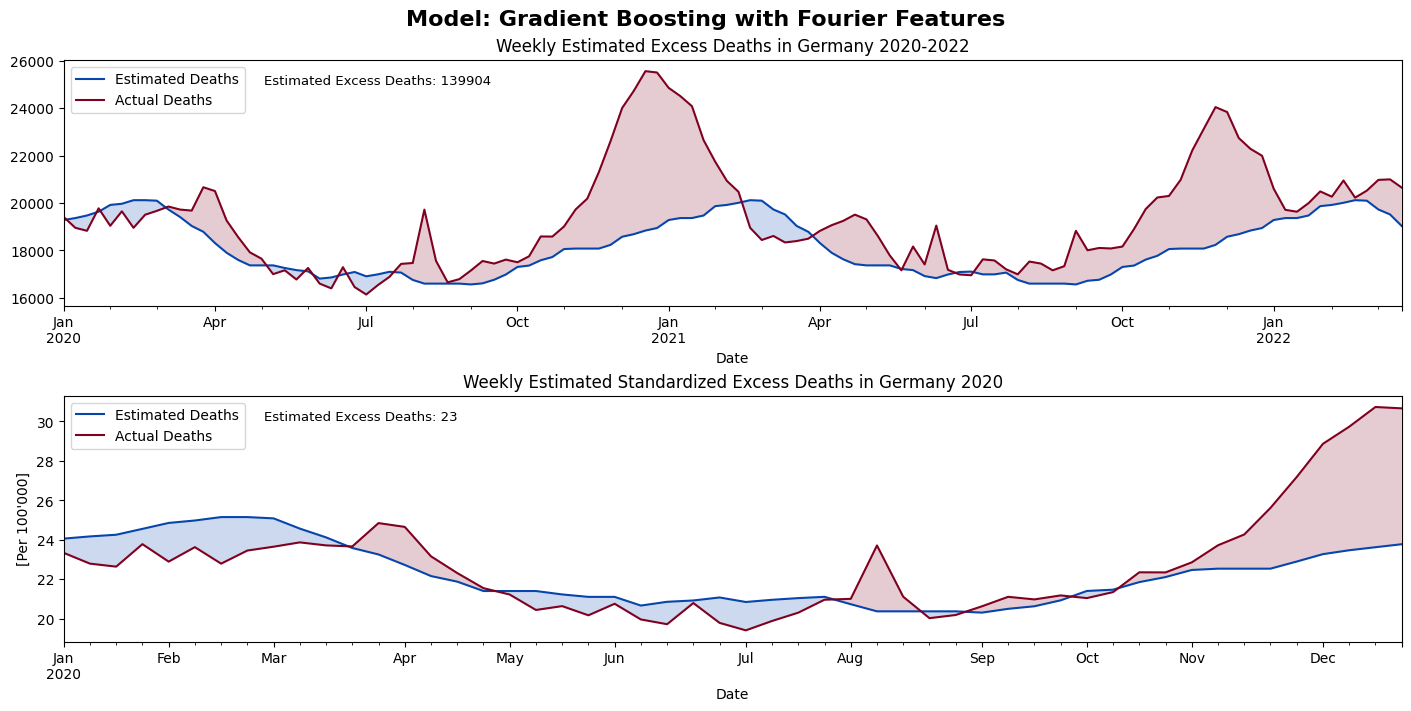

In [19]:
model = GradientBoostingRegressor(max_depth=1)

# Generate features and labels to train the model.
Weekly_Deaths_comb_train = Weekly_Deaths[(Weekly_Deaths.index.year < 2020) & (Weekly_Deaths.index.year >= 2008)] # Former validation set will be added to the training set.

dp = DeterministicProcess(index=Weekly_Deaths_comb_train.index.to_period("W"),
                          constant=True,                # dummy feature for bias (y-intercept)
                          order=1,                      # trend (order 1 means linear)
                          additional_terms=[fourierA],)  # annual seasonality (fourier)

X_train_f = dp.in_sample() # Generate features for model. X_train is already used in section 5, hence add _f for "final" to variable name.

Datasets = [(X_train_f, Weekly_Deaths_comb_train, Weekly_Deaths_test,
             "Weekly Estimated Excess Deaths in Germany 2020-2022", ""),
            (X_train_f, Weekly_Deaths_standardized_train, Weekly_Deaths_standardized_test,
             "Weekly Estimated Standardized Excess Deaths in Germany 2020", "[Per 100'000]"),]

# Plot results.
fig, ax = plt.subplots(2, layout="constrained", figsize=(14,7))
for i,data in enumerate(Datasets):
    X_train_f, y_train_f = data[0], data[1]
    y_test_true = data[2].Value
    description, ylabel = data[3], data[4]
    # Fit and predict step.
    model.fit(X_train_f, y_train_f)

    test_index = y_test_true.index
    X_test = dp.out_of_sample(len(test_index), test_index)
    y_test_pred = pd.Series(model.predict(X_test).reshape(-1), index=test_index)

    excess_deaths = np.sum(y_test_true - y_test_pred)
    
    # Code for plotting.
    ax[i].axes.annotate(f"Estimated Excess Deaths: {excess_deaths:.0f}", xy=(0.15,0.9), xycoords='axes fraction', fontsize=9.5)
    ax[i].set_ylabel(ylabel)
    y_test_pred.plot(ax=ax[i], label="Estimated Deaths")
    y_test_true.plot(ax=ax[i], label="Actual Deaths").set_title(description)
    ax[i].fill_between(test_index, y1=y_test_pred , y2=y_test_true, where=y_test_true <= y_test_pred, facecolor='#0645ad', alpha=0.2,interpolate=True)
    ax[i].fill_between(test_index, y1=y_test_pred , y2=y_test_true, where=y_test_true >= y_test_pred, facecolor='#800020', alpha=0.2,interpolate=True)
    ax[i].legend(loc="upper left")
plt.suptitle("Model: Gradient Boosting with Fourier Features", fontsize="16",fontweight="bold") 
#plt.savefig("Weekly Estimated Excess Deaths 2020.png", dpi=200)

### 9.2. Raw  Deaths per 100'000

Since the estimate of the standardized deaths are per 100'000 we need to apply a bit of arithmetic to transform the raw death estimates in the first subplot into estimates per 100'000 in order to make a proper comparisson between the model predictions. Since the time frame of the two data sets also differs we need our model to give us an estimate of the raw deaths for 2020 solely. According to the DESTATIS the population of Germany was 83,24 million. Dividing our model estimate for the raw deaths in 2020 by this number yields 58 excess deaths per 100000, more than double the age standardized rate. 

In [20]:
Weekly_Deaths_2020 = Weekly_Deaths_test[Weekly_Deaths_test.index.year == 2021].Value
model.fit(X_train_f, Weekly_Deaths_comb_train)

test_index = Weekly_Deaths_2020.index
X_test = dp.out_of_sample(len(test_index), test_index)
Weekly_Deaths_2020_estimate = pd.Series(model.predict(X_test).reshape(-1), index=test_index)

population_2020 = 832.4
excess_deaths_per_100k = np.sum(Weekly_Deaths_2020 - Weekly_Deaths_2020_estimate) / population_2020
print(f"Raw Estimated Excess Deaths: {excess_deaths_per_100k:.0f}")

Raw Estimated Excess Deaths: 98


### 9.3. Applying the SARIMA model
We now apply our SARIMA model to both datasets. As shown in section 7 the SARIMA model is competitive with the Gradient boosting model and manages to get rid of the autocorrelation of the residuals on the training data, which are also normaly distributed in case of the SARIMA model. We can therefore generate confindence intervals for the model, which are displayed in grey.

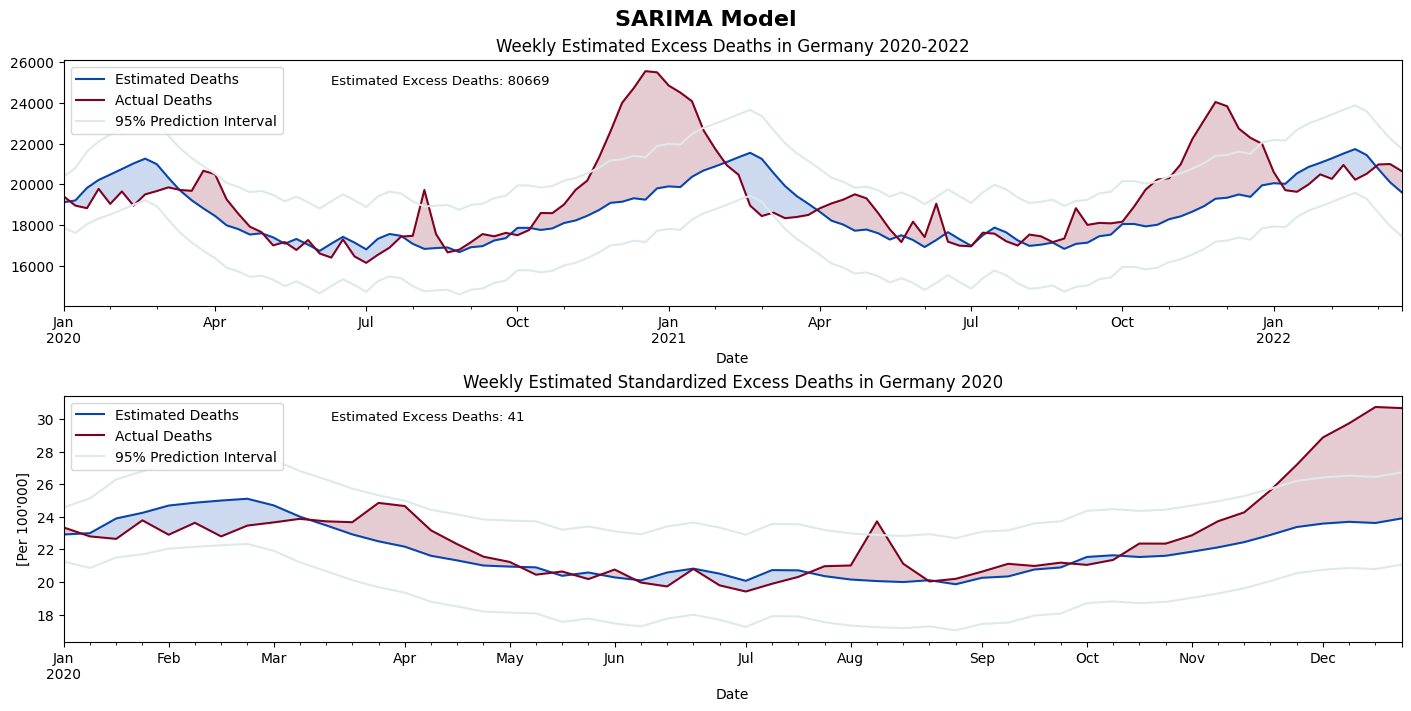

In [21]:
model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,52))

Datasets = [(Weekly_Deaths_comb_train, Weekly_Deaths_test,
             "Weekly Estimated Excess Deaths in Germany 2020-2022", ""),
            (Weekly_Deaths_standardized_train, Weekly_Deaths_standardized_test,
             "Weekly Estimated Standardized Excess Deaths in Germany 2020", "[Per 100'000]"),]

# Plot results.
fig, ax = plt.subplots(2, layout="constrained", figsize=(14,7))
for i,data in enumerate(Datasets):
    train_values = data[0]
    test_values = data[1].Value
    test_index = test_values.index
    description, ylabel = data[2], data[3]
    # Fit and predict step.
    model = SARIMAX(train_values - train_values.mean(), order=(1,1,1), seasonal_order=(1,1,1,52))
    model_fit = model.fit()

    predictions = model_fit.get_forecast(len(test_values))
    predictions_mean = predictions.predicted_mean.add(train_values.mean().Value)
    pred_lower_bound = predictions.conf_int()["lower Value"].add(train_values.mean().Value)
    pred_upper_bound = predictions.conf_int()["upper Value"].add(train_values.mean().Value)

    excess_deaths = np.sum(test_values - predictions_mean)
    
    # Code for plotting.
    ax[i].axes.annotate(f"Estimated Excess Deaths: {excess_deaths:.0f}", xy=(0.2,0.9), xycoords='axes fraction', fontsize=9.5)
    ax[i].set_ylabel(ylabel)
    predictions_mean.plot(ax=ax[i], label="Estimated Deaths")
    test_values.plot(ax=ax[i], label="Actual Deaths").set_title(description)
    pred_lower_bound.plot(ax=ax[i], c="#DDEAE9", label="95% Prediction Interval")
    pred_upper_bound.plot(ax=ax[i], c="#DDEAE9", label="")
    ax[i].fill_between(test_index, y1=predictions_mean , y2=test_values, where=test_values <= predictions_mean, facecolor='#0645ad', alpha=0.2,interpolate=True)
    ax[i].fill_between(test_index, y1=predictions_mean , y2=test_values, where=test_values >= predictions_mean, facecolor='#800020', alpha=0.2,interpolate=True)
    ax[i].legend(loc="upper left")
    
plt.suptitle("SARIMA Model", fontsize="16",fontweight="bold") 
plt.savefig("SARIMA Weekly Estimated Excess Deaths 2020-2022.png", dpi=200)

## 10. Sources
1. Hastie, T., Tibshirani, R., Friedman, J. (2009). The elements of statistical learning: data mining, inference and prediction. Springer.
2. Ashbacher, C. (2005). All the Mathematics You Missed (But Need to Know for Graduate School). School Science and Mathematics
3. Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp2/. Accessed on <01.05.2022>.
4. Redenbach, C. (2020). Lecture Notes - Regression and Time Series Analysis. TU Kaiserslautern SS20.
5. Arens, T. Hettlich, F., Karpfinger, C., Kockelkorn, U., Lichtenegger, K., Stachel, H. (2018). Mathematik. Springer
6. Holbrook, R., Cook, A. (07.05.2022) *Time Series*. Kaggle. https://www.kaggle.com/learn/time-serie
7. A Karlinsky, D Kobak - Elife, 2021, Tracking excess mortality across countries during the COVID-19 pandemic with the World Mortality Dataset